Note: you may need to install the following packages to run this notebook:

1. Shapely -- see https://pypi.org/project/Shapely/ for installation instructions.
2. Descartes -- see https://docs.descarteslabs.com/installation.html for installation instructions.
3. Pydot-ng -- see https://pypi.org/project/pydot-ng/
4. Netwrokx -- see https://pypi.org/project/networkx/

In [3]:
# Useful imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
#from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
#import yaml
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly, random_environment
import random as random


# Aerial Delivery and Research Support

## **The Problem** 

You lead the operations team for a group of researchers operating at remote locations throughout the Denali Wilderness. From your base camp in Denali National Park, you are responsible for delivering food, medical supplies, and equipment to the research teams located at 4 different locations throughout the wilderness--they endeavor to work at these locations throughout the summer. You are also responsible for supporting their research requirements to include maintenance of scientific equipment.

*Add in some cool pictures*

The terrain in Denali is extremely rugged and consists of a mix of taiga forests, high tundra, glaciers, and mountains. The research teams operate in locations unreachable by road and the scientists get in place by hiking in and out of their working locations. Currently supplies are delivered in the same way. This makes maintaining a continuous research presence extremely difficult as weather events, unexpected supply shortages, and other operational issues often lead to dangerously low provisions at the research sites--forcing the scientists to return intermittently to ensure the safety of the team.

Fortunately your team has just come into possession of 7 drones who are capable of delivering supplies to the teams. Your task is to:

<ol>
    <li><b> Plan routes between all sites and the base camp avoiding designated no-fly areas.</b></li>
    <li><b> Develop a supply delivery schedule based upon your planned routes, your drone delivery capabilities, and research team needs.</b></li>
    <li><b> Develop a method to diagnose scientific equipment faults and issues to determine when equipment supplies need to be delivered to a team.<b/></li>
</ol>

## **Route Planning with RRT and RRT*** 

Your drones can overfly most of terrain between you and the research teams but must take care to avoid areas designated noise sensitive due to wildlife, ecologically sensitive areas where it is deemed completely unnacceptable for a drone to crash, and campsites in the national park near your launch location. All of these areas were designated no-fly areas by the Bureau of Land Management and the National Park Service. Finally, some high altitude areas cannot be overflown due to drone performance limitations.

Your team has developed a map depicting these no-fly areas, your base camp, and the research sites. Anything outside the map boundaries is also considered a no-fly area. Based on the ecological sensitivity of Denali (and the importance that the National Park Service puts on keeping the wilderness as pristine as possible!) there are <ins> a lot </ins> of no-fly areas. Your drones can be relied upon to stay within 100 meters of any planned path (this navigation error will be exceeded with a probability of 10<sup>-5</sup> in any given flight-hour so it's acceptable use this number for path planning!).

Due to the high latitude of your operations, your team uses a grid system to specify camp locations referenced to True North. For the remote camps, you are provided with a landing zone (LZ) geometry. Each unit digit on the grid system represents one kilometer. Hence, location (-4,-2) is one kilometer *true* south of position (-3,-2).

Based on this grid system, the relevant locations are:

<ul class="dashed">
  <li>The base camp drone launch site is located at position (-2,-2)</li>
  <li>The site 1 LZ bounds are (-4.5,3.6), (-4.5,4), (-4.2,4),(-4.2,3.6).</li>
  <li>The site 2 LZ bounds are (9.7,0), (9.7,0.4), (10,0.4),(10,0).</li>
   <li>The site 3 LZ bounds are (12.7,3.6), (12.7,4), (13,4),(13,3.6).</li>
   <li>The site 4 LZ bounds are (13.6,-3.2), (13.6,-3.5), (14,-3.5),(14,-3.2).</li>
</ul>

**The code block below shows the map of the no-fly areas (in blue), the base camp (in magenta), and the LZs (in green).**

C:\Users\Aadi\PADM_Project\environment.py:138: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  polygon.name = name
C:\Users\Aadi\Anaconda3\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


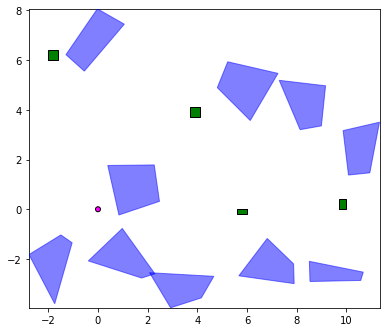

In [4]:
# Plot the environment 
env = Environment('simple.yaml')
ax = plot_environment(env)

# Base camp location
radius = 0.1
start_pose = (0,0)
start_poly = Polygon([(start_pose[0],start_pose[1]), (start_pose[0]-0.4,start_pose[1]), (start_pose[0]-0.4,start_pose[1]+0.4),(start_pose[0]+0.4,start_pose[1]+0.4)])
start_point = Point(start_pose[0],start_pose[1])
start_ball = start_point.buffer(radius)

# Camp locations
LZ1 = Polygon([(4.1,4.1), (3.7,4.1), (3.7,3.7),(4.1,3.7)])
LZ2 = Polygon([(9.7,0), (9.7,0.4), (10,0.4),(10,0)])
LZ3 = Polygon([(6,0), (5.6,0), (5.6,-0.2),(6,-0.2)])
LZ4 = Polygon([(-2,6), (-2,6.4), (-1.6,6.4),(-1.6,6)])

LZs = (LZ1, LZ2, LZ3, LZ4)
loc_coord = [start_pose, ((4.1+3.7)/2, (4.1+3.7)/2), ((9.7+10)/2, (0+0.4)/2), ((6+5.6)/2, (0-0.2)/2), ((-2-1.6)/2, (6+6.4)/2)]
loc_poly = [start_poly, LZ1, LZ2, LZ3, LZ4]
# Plot base camp in magenta
plot_poly(ax, start_ball,'magenta')
# Plot research camps in green
for LZ in LZs:
    plot_poly(ax, LZ,'green')

<ins>**Rapidly Exploring Random Trees (RRT)**</ins>

Looking at the map, you are a bit baffled in how you can make sure you find the best routes through this maze. Fortunately, you took 16.413 at MIT and recall learning about sampling-based planning methods--in particular Rapidly Exploring Random Trees (RRT). You decide to first tackle this problem with RRT. We chose RRT over graph search primarily due to the curse of dimensionality as highlighted in the course. For a better path, we would like to discretize our map further which exponentially increases the node size in case of a graph search algoithm. Further, we can also incoporate our agent's dynamics using RRT since we simulate forward (much harder to implement in probabilistic roadmap planning).

**Academic description of RRT**
In RRT (Rapidly Exploring Random Trees), the search tree is incrementally generated using samples from search space in a random fashion. In the iterative process:
<li> A random coordinate is chosen in free space </li>
<li> Find the nearest vertex exisiting in the tree to that coordinate</li>
<li> Steer that vertex in the direction of the coordinate by a depth d</li>
<li> If the new vertex is obstacle free, add it to our tree.</li>
<li> Repeat the above steps until the vertex lands in the goal region</li>
RRT is probabilistically complete which means that it will find a solution in case the solution exists (though it may take a long time to run). A few downsides of RRT are that it usually returns a suboptimal path and also fails to check if a path does not exist (i.e. the algorithm will run forever in case the path between start and goal location does not exist).

**RRT Demo going from Base Camp --> LZ1, discuss how non-optimal**

Taking a look at the produced route, you can tell by inspection that the route is clearly not optimal. Thankfully, you remember that there is an optimal version of RRT, RRT* that you should be able to implement for this problem.

<b> Academic description of RRT* </b>
RRT* is an optimized version of RRT, and is asymptotically optimal. In an ideal case when number of nodes tend to infinity, RRT* yields the shortest path (optimal path) to the goal by keeping track of the distance each vertex has travelled relative to the parent vertex. Another variation is that after a vertex is added to the lowest cost neighbor, the tree is rewired to the new vertex in order to decrease individual cost. In the the iterative process:
<li> A random coordinate is chosen in free space that is not in any obstacle</li>
<li> Find the nearest node existing in the tree to that coordinate</li>
<li> Store the cost i.e. the distance between the nearest node to the coordinate </li>
<li> Examine neighbors within a specified radius of the new node and updates costs for them if combined cost with the new node turns out to be less than the existing cost of that neighbor.</li>
<li> Update parent of that graph and the node accordingly.</li>
<li> Repeat the above steps until the vertex lands in the goal region</li>
Note: Instead of the above terminating condition, we can run the code for more iterations to find a better (more optimal) path. Also, if we have the agent dynamics, we can find the "nearest node" that is closest to the possible achievable states of the agent.

<ins>**Motion planning solution summarazied**</ins>
**Input** : The map of the delivery region and the coordinates of the basecamp and the five destinations <br>
**Output** : The distance matrix between basecamp and destinations <br>
**Method** : Run RRT/RRT* among all points (basecamp and destinations) and populate with the shortest distance <br>

# **Linear programming module for determinnig optimal vehicle routes***
Through the RRT/RRT* module we will populate shortest path from basecamp to each drop points and from each drop point to every other drop point. Once this data is populated, then we plan to use a Linear Programming (LP) model to determine the optimial routes for each drone ( The objective of LP model is to tell how many drones to use, specificificallly which drone to use (based on the drone properties of weight and volume capacity), the route of each drone ( which drop points and the sequence each drone will use) and the cost of the entire process.


## **A. Concept Introduction** <br>
LP is a method employed to maximize or minimize an objective function (represented by a mathemetical equation) against constraints which are linearly related to the decision variables. The three major components of a LP is 
<br><br>
(i) Objective function : What the model should maximize or minimize . This is usually modelled mathematically using the decision variables and constants. Refer Mathematical model, in which we explain how we are defining the obejctive fucntion for our model . 
<br>
(ii) Decision Variables : These are the variables that the LP model optimizes ( or iterates with ) to achieve the objective function <br>
(iii) Constraints : These are the relationships or bounds for the decision variables that the model needs to ensure is within the limits . For LP models, these relations needs to be Linear in nature
<br><br>
The standrad form of a LP is shown below <br>
<br>
Find a vector  **c**        <-- Decision Variable <br>
that maximizes $  cT * x $   <-- Objective Functiobn <br>
subkect to     $ Ax <= B $  <-- Constraint #1 <br>
and            $ x >= 0 $   <-- Constraint #2<br>

## **B. LP Model for Aerial delivery system**
### **1.Objective function** : <br>
The objective function is to **minimize the total cost of transportation**. <br> 
Out intention is to have 2 components to total cost. <br>
Total Cost = Fixed Cost + Variable Cost <br>
Fixed cost : Fixed cost of using the drone (Lease or rental charges) <br>
Variable Cost : Cost incurred by using the drone (Chargings costs, Maintenance costs all defined as USD per Km) <br>

### **2. Parameters or Input to the Program** : <br>
1. Distance matrix between each point to every other point (including basecamp and drop points) from RRT/RRT* <br> 
2. Fixed cost of using the drone ~ USD / Day <br>
3. Variable cost of using the drone ~ USD/ KM <br>
4. Averge speed of the drone ~ km/hr <br>
5. Weekly demand of each drop point in terms of weight (tons) and volume (cubic meter)<br>
6. Capacity of drone in terms of weight (tons) and volume (cubic meter)<br>
7. Eficiency of drone could be used ( % of weight or volume capacity could be used to transport)<br>

### **3. Decisions Variable** : <br>
For the constraints i,j refers to basecamp (i,j=0) and drop points (i,j = 1 to 4), d refers to trip number, t refers to drone type <br>
1. X refers to the % of demand moved from basecamp to each drop point in a patricular drone ~ $ X_{ijdt} $  (between 0 and 1) <br> 
2. Y refers to whether a drone is used or not ~ $ Y_{dt} $ (binary) <br>

### **4. Constraints** : <br>
These constraints are our initial thoughts to these models, <br>
For the constraints i,j refers to basecamp (i,j=0) and drop points (i,j = 1 to 4), d refers to trip number, t refers to drone type <br>
1. We need to restrict movement of goods from each drop point to same drop point ( $ X_{ii} = 0 $ )
2. Relationship between Y and X . If X > 0 for a trip in a day , then Y should be 1 for that trip, 0 otherwise 
3. The net demand of each warehouse is met. (Sum across all d,t ( $ X_{i} = 100% $ ) 
4. Load in the drone is within the weight and volume capacity
5. Subtour elimination constraints ( to ensure that vehicle does not get into cycles and get stuck)
6. Balacning constraint ( at every destination what comes in goes out )

7. X is percentage between 0 and 1
8. Y is binary


###### Below this line is only trials #

In [5]:
import numpy as np
from pulp import *

In [6]:
# Define the maps containing start and goal nodes along with obstacles

In [200]:
#Working RRT
import pdb
from utils import *
from graph import Graph, Edge
from search_classes import SearchNode, Path

def rrt(bounds, environment, start_pose, radius, end_region):
    counter = 0
    d = 0.2 #steer distance 
    graph = Graph()
    graph.add_node(start_pose)
    # Draw the environment (with its obstacles)
    ax = plot_environment(environment, bounds)
    # Draw the start and end poses
    plot_poly(ax, Point(start_pose).buffer(radius, resolution=3),'magenta')
    plot_poly(ax, end_region,'brown', alpha=0.2)
    while True:
        Xrand = (np.random.uniform(bounds[0], bounds[2]), np.random.uniform(bounds[1], bounds[3]))
        if collision_point(Point(Xrand), environment):
            continue
        Xnearest = Nearest(graph, Xrand)
        Xnew = Steer(Xnearest, Xrand, d)
        
        line = LineString([Xnearest, Xnew])
        expanded_line = line.buffer(radius, resolution=3)
        
        if not collision_line(expanded_line, environment):
            plot_line(ax, line)
            graph.add_node(Xnew)
            graph.add_edge(Xnew, Xnearest, 1, False)
        if end_region.contains(Point(Xnew)):
            break
    Xgoal = Xnew
    path = [Xnew]

    while True:
        edges = graph._edges[Xnew]
        if len(edges) == 1:
            Xprev = list(edges)[0].target
            path.insert(0, Xprev)
            Xnew = list(edges)[0].target
        if Xnew == start_pose:
            break
    path_len = 0
    for ind in range(len(path) - 1):
        line = LineString([path[ind], path[ind+1]])
        expanded_line = line.buffer(radius, resolution=3)
        plot_poly(ax, expanded_line, 'green', alpha=0.2)
        x,y = path[ind]
        xnxt, ynxt  = path[ind+1]
        path_len += np.sqrt((x - xnxt)**2 + (y - ynxt)**2)
    plt.title("Number of nodes in the tree %i . Number of nodes in the path %i. Path length %f" %(len(graph._nodes), len(path), path_len))
    return (path, path_len)

def Steer(Xnearest, Xrand, d):
    dirn = np.array(Xrand) - np.array(Xnearest)
    length = np.linalg.norm(dirn)
    dirn = (dirn / length) * min (d, length)

    Xnew = (Xnearest[0]+dirn[0], Xnearest[1]+dirn[1])
    return Xnew
def Nearest(graph, Xrand):
    min_dist = np.inf
    nearest_node = ()
    for node in graph._nodes:
        euc_dist = np.sqrt((node[0] - Xrand[0])**2 + (node[1] - Xrand[1])**2)
        if euc_dist < min_dist:
            min_dist = euc_dist
            nearest_node = node
    return nearest_node
def collision_line(expanded_line, env):
    for i, obs in enumerate(env.obstacles):
        # Check collisions between the expanded line and each obstacle
        if expanded_line.intersects(obs):
            return True
    return False
def collision_point(point, env):
    for i, obs in enumerate(env.obstacles):
        # Check if point is inside obstacle
        if obs.contains(point):
            return True
    return False


[[ 0.         12.58766661 15.4         6.93722553  8.        ]
 [12.58766661  0.          8.6         6.2         8.        ]
 [15.4         8.6         0.          7.74523675 16.2       ]
 [ 6.93722553  6.2         7.74523675  0.         14.58402599]
 [ 8.          8.         16.2        14.58402599  0.        ]]


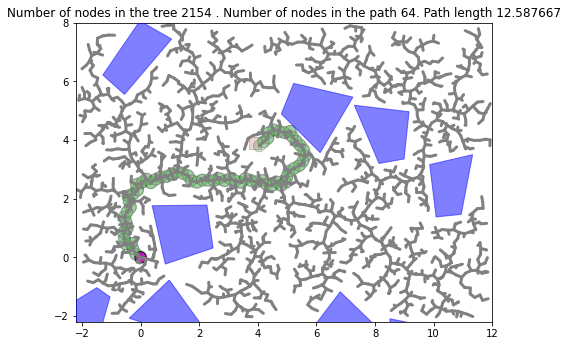

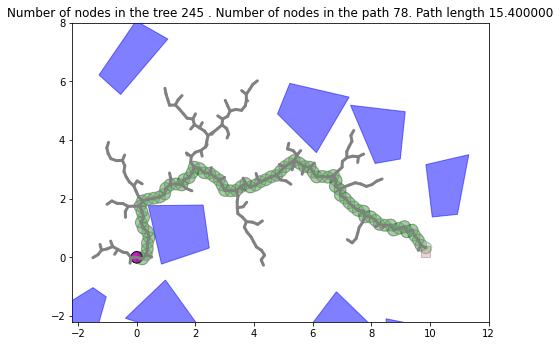

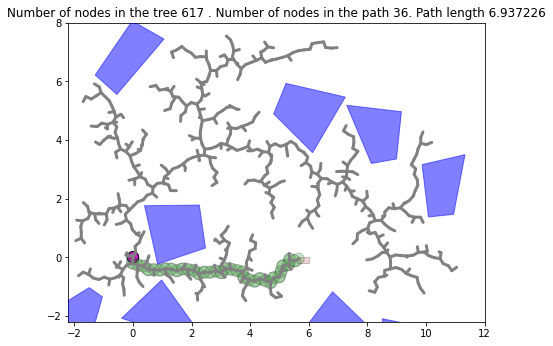

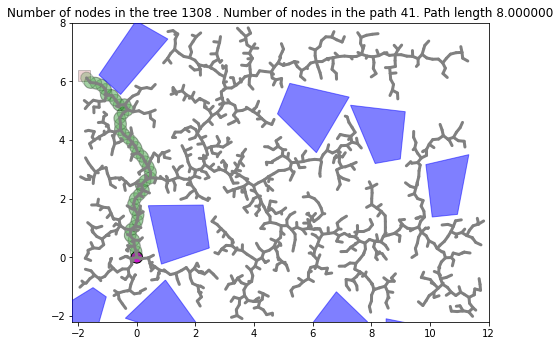

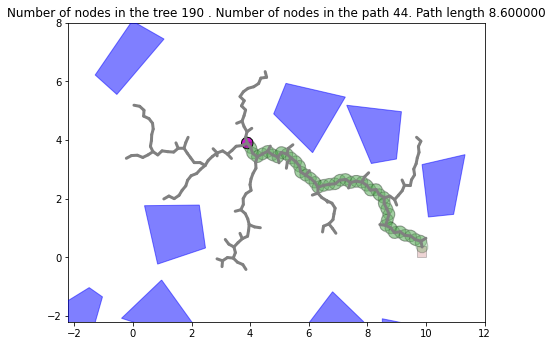

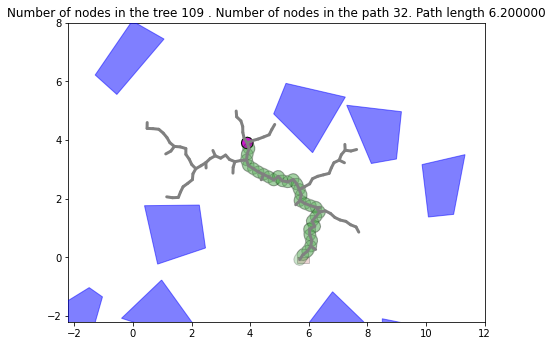

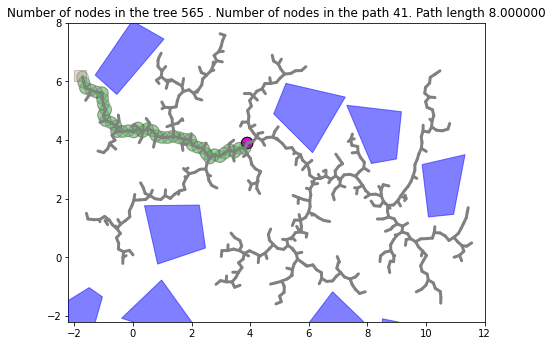

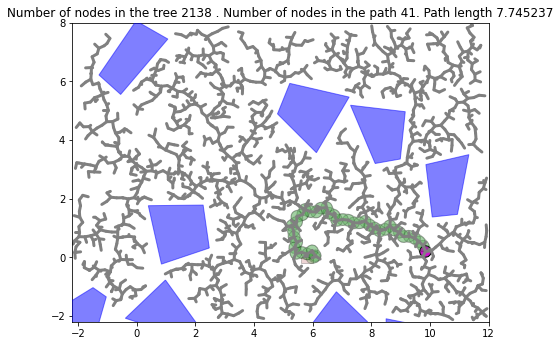

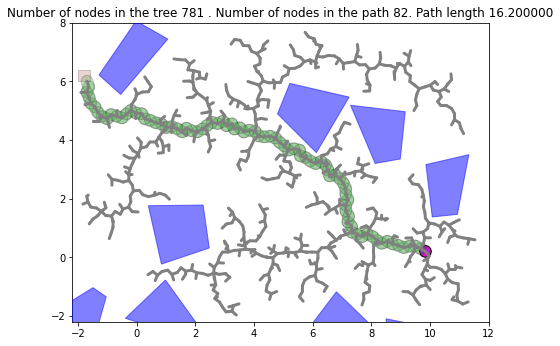

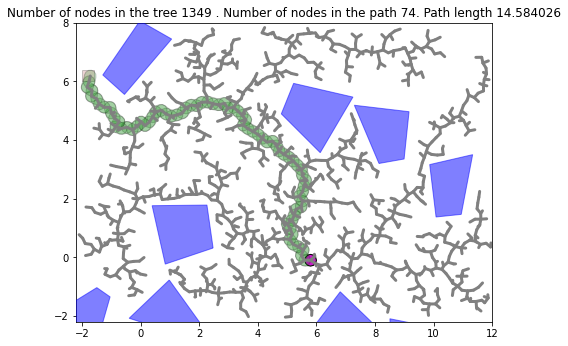

In [201]:
# Populate distance matrix using rrt
from shapely.geometry import Point, Polygon, LineString, box
radius = 0.2
bounds = (-2.2, -2.2, 12, 8)
distance_rrt = np.empty((5,5))

for ind1 in range(len(distance_rrt)):
    distance_rrt[ind1,ind1] = 0
    for ind2 in range(ind1+1, len(distance_rrt)):
        start = loc_coord[ind1]
        goal_region = loc_poly[ind2]
        path, path_len = rrt(bounds, env, start, radius, goal_region)
        distance_rrt[ind1][ind2] = path_len
        distance_rrt[ind2][ind1] = path_len
print(distance_rrt)

In [68]:
# Use RRT/RRT* to calculate the optimal distance matrix coresponding to the distances between basecamp and destinations
import pdb
from utils import *
from graph import Graph, Edge
from search_classes import SearchNode, Path

def euc_distance(x, y):
    dist = np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    return dist
def findNeighbors(graph, Xnew, rad, cost, start_pose, environment):
    Xneighbors = []
    Xbest = ()
    min_dist = np.inf
    for node in graph._nodes:
          
        dist_to_node = euc_distance(node, Xnew)
        if  dist_to_node <= rad:
            Xneighbors.append(node)
        
        if(path_cost(graph, start_pose, node) + dist_to_node) < min_dist: #if (dist_to_node + cost[node]) < min_dist:
            #line = LineString([Xnew, node])
            #expanded_line = line.buffer(radius, resolution=3)
            #if collision_line(expanded_line, environment):
            #    continue
            Xbest = node
            min_dist = path_cost(graph, start_pose, node) + dist_to_node#+ cost[node]
    return Xbest, Xneighbors
def Steer(Xnearest, Xrand, d):
    dirn = np.array(Xrand) - np.array(Xnearest)
    length = np.linalg.norm(dirn)
    dirn = (dirn / length) * min (d, length)

    Xnew = (Xnearest[0]+dirn[0], Xnearest[1]+dirn[1])
    return Xnew
def Nearest(graph, Xrand):
    min_dist = np.inf
    nearest_node = ()
    for node in graph._nodes:
        euc_dist = np.sqrt((node[0] - Xrand[0])**2 + (node[1] - Xrand[1])**2)
        if euc_dist < min_dist:
            min_dist = euc_dist
            nearest_node = node
    return nearest_node
def collision_line(expanded_line, env):
    for i, obs in enumerate(env.obstacles):
        # Check collisions between the expanded line and each obstacle
        if expanded_line.intersects(obs):
            return True
    return False
def collision_point(point, env):
    for i, obs in enumerate(env.obstacles):
        # Check if point is inside obstacle
        if obs.contains(point):
            return True
    return False
def path_cost(graph, x_init, x_new):
    path_dist = 0
    while not x_init == x_new:
        edges = graph._edges[x_new]
        path_dist += list(edges)[0].weight
        x_new = list(edges)[0].target
    return path_dist

In [95]:
def rrt_star(bounds, environment, start_pose, radius, end_region): 
    # Hyper parameters:
    
    line_plot_rad = 0.01
    iter = 10 # Iterations for rrt_star
    rad = 0.3 # RRT* radius lookup
    d = 0.25 # steer distance 
    
    graph = Graph()
    graph.add_node(start_pose)
    
    # Draw the environment (with its obstacles)
    ax = plot_environment(environment, bounds)
    # Draw the start and end poses
    plot_poly(ax, Point(start_pose).buffer(radius, resolution=3),'magenta')
    plot_poly(ax, end_region,'brown', alpha=0.2)
    
    cost = dict() # Stores cost of each node of the graph
    Xgoal = () # S\tore goal position node
    cost[start_pose] = 0
    flag = 0
    count = 0
    while True:
        Xrand = (np.random.uniform(bounds[0], bounds[2]), np.random.uniform(bounds[1], bounds[3]))
        if collision_point(Point(Xrand), environment):
            continue
        Xnearest = Nearest(graph, Xrand)
        Xnew = Steer(Xnearest, Xrand, d)
        dist = euc_distance(Xrand, Xnearest)
        if dist < d:
            Xnew = Xrand
            
        Xbest, Xneighbors = findNeighbors(graph, Xnew, rad, cost, start_pose, environment)
        if Xbest == ():
            continue
        # Collision check:
        line = LineString([Xnew, Xbest])
        expanded_line = line.buffer(radius, resolution=3)
        if collision_line(expanded_line, environment):
            continue  
        #plot_line(ax, line)
        
        # Find cost of new node and add it to the graph
        cost[Xnew] = path_cost(graph, start_pose, Xbest) + euc_distance(Xbest, Xnew) #+ cost[Xbest]
        graph.add_node(Xnew)
        graph.add_edge(Xnew, Xbest,  euc_distance(Xnew, Xbest), False)
        
        # Iterate through neighbors to rewire the tree
        for x_prime in Xneighbors:
            if (cost[Xnew] + euc_distance(Xnew, x_prime)) < cost[x_prime]:
                cost[x_prime] = cost[Xnew] + euc_distance(Xnew, x_prime)
                #Rewire the tree
                graph.delete_edge(x_prime)
                graph.add_edge(x_prime, Xnew, euc_distance(x_prime, Xnew), False)
        
        # While loop iteration play:
        count = count + 1
        if flag == 0:
            count = 0
        if count > iter:
            break
        if end_region.contains(Point(Xnew)) and flag ==0:
            Xgoal = Xnew
            flag = 1
            
    Xnew = Xgoal
    path = [Xnew]
    
    # Prtinting graph on the map
    for node in graph._edges.keys():
        for edge in graph._edges[node]:
            child = edge.target
            parent = edge.source
            line = LineString([child, parent])
            expanded_line = line.buffer(line_plot_rad, resolution=1)
            plot_poly(ax, expanded_line, 'black', alpha=0.5)
    
    # Extracting path of the solution
    while True:
        edges = graph._edges[Xnew]
        if len(edges) == 1:
            Xprev = list(edges)[0].target
            path.insert(0, Xprev)
            Xnew = list(edges)[0].target
        if Xnew == start_pose:
            break
    path_len = 0
    for ind in range(len(path) - 1):
        line = LineString([path[ind],path[ind+1]])
        expanded_line = line.buffer(radius, resolution=3)
        plot_poly(ax, expanded_line, 'green', alpha=0.75)
        x,y = path[ind]
        xnxt, ynxt  = path[ind+1]
        path_len += np.sqrt((x - xnxt)**2 + (y - ynxt)**2)
    plt.title("Number of nodes in the tree %i . Number of nodes in the path %i. Path length %f" %(len(graph._nodes), len(path), path_len))
    return (path, path_len)


[(0, 0), (0.159894101034732, 1.8576637904969515), (0.41003958670072105, 2.0232754929848085), (3.890961728794182, 3.8273888647480954)]


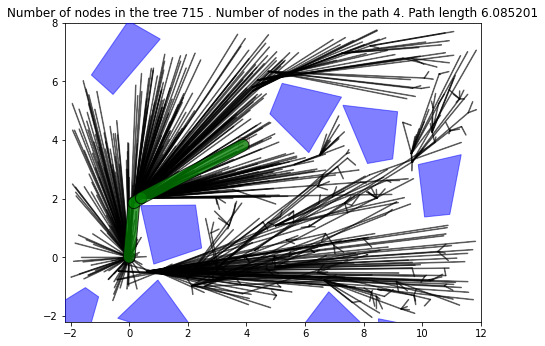

In [94]:
from shapely.geometry import Point, Polygon, LineString, box
radius = 0.2
bounds = (-2.2, -2.2, 12, 8)
distance_rrt_star = np.empty((5,5))
path,path_len = rrt_star(bounds, env, start_pose, radius, LZ1)

Working on 0 1
Working on 0 2
Working on 0 3
Working on 0 4
Working on 1 2
Working on 1 3
Working on 1 4
Working on 2 3
Working on 2 4
Working on 3 4
[[ 0.          6.24854228  9.9150125   5.8385539   6.43939776]
 [ 6.24854228  0.          7.16653866  4.45609725  6.25344636]
 [ 9.9150125   7.16653866  0.          3.95542567 13.1681677 ]
 [ 5.8385539   4.45609725  3.95542567  0.          9.86589911]
 [ 6.43939776  6.25344636 13.1681677   9.86589911  0.        ]]


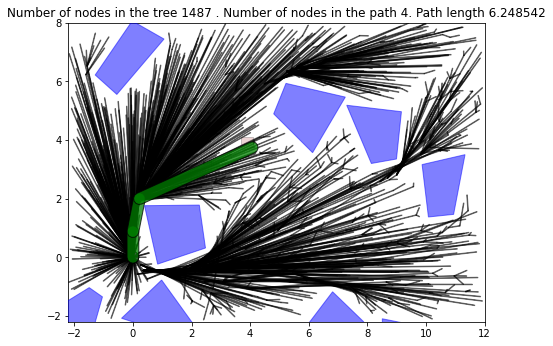

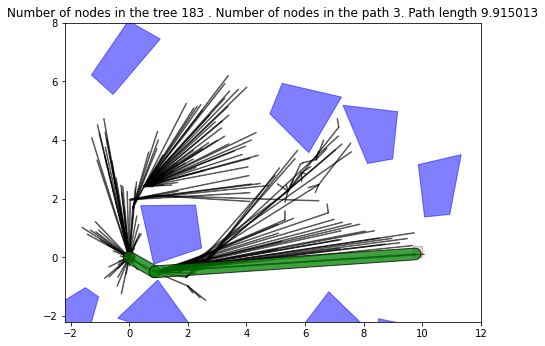

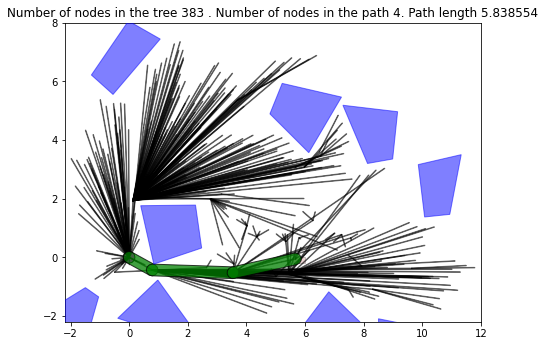

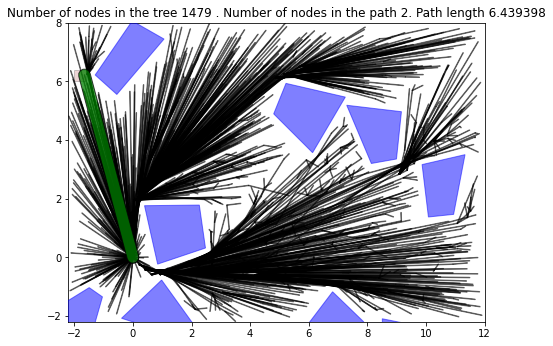

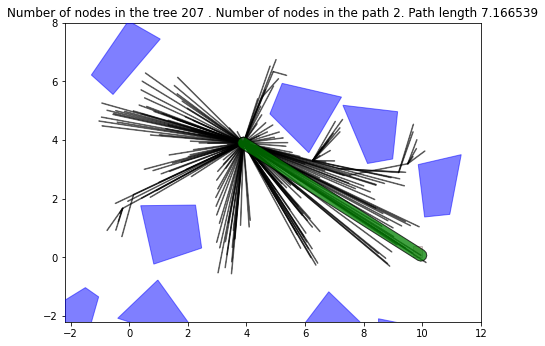

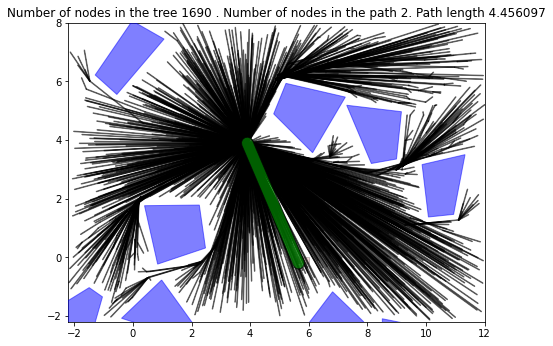

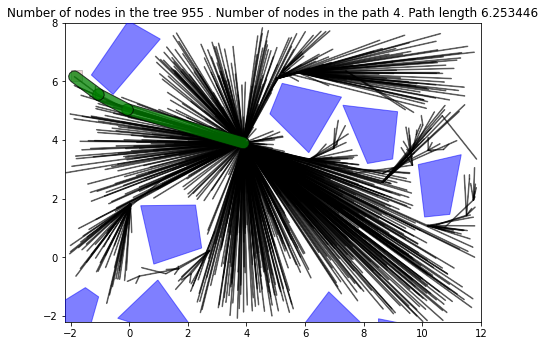

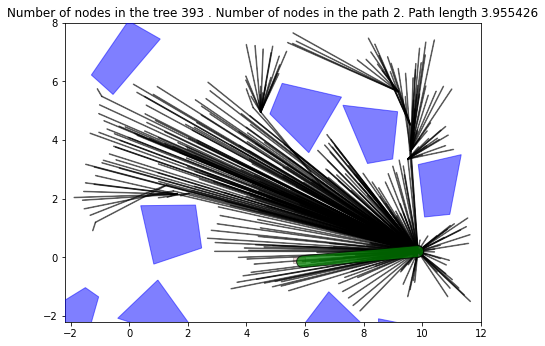

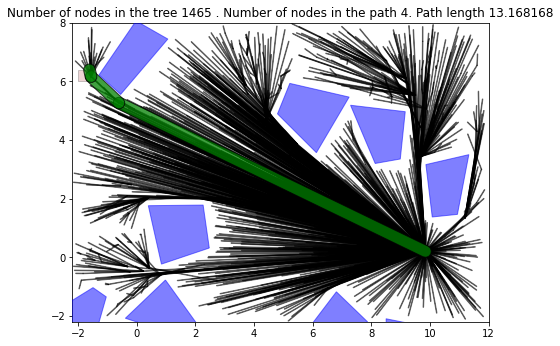

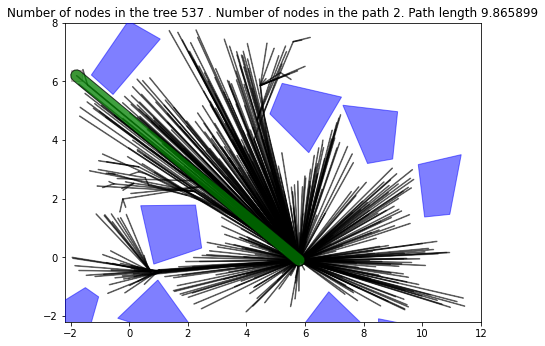

In [99]:
from shapely.geometry import Point, Polygon, LineString, box
radius = 0.2
bounds = (-2.2, -2.2, 12, 8)
distance_rrt_star = np.empty((5,5))
#path,path_len = rrt_star(bounds, env, start_pose, radius, LZ4)
for ind1 in range(len(distance_rrt_star)):
    distance_rrt_star[ind1,ind1] = 0
    for ind2 in range(ind1+1, len(distance_rrt_star)):
        print("Working on %i %i" %(ind1, ind2))
        start = loc_coord[ind1]
        goal_region = loc_poly[ind2]
        path, path_len = rrt_star(bounds, env, start, radius, goal_region)
        distance_rrt_star[ind1][ind2] = path_len
        distance_rrt_star[ind2][ind1] = path_len
print(distance_rrt_star)


In [176]:
iter = [(i,j,d,t) for t in range(nTrucks) for d in range(nTrips) for j in range(nSuppliers) for i in range(nSuppliers)]
# Decision variables
X_ijdt = LpVariable.dicts("X",(Supp,Supp, Trips, Trucks),0,1)
Y_dt = LpVariable.dicts("Y",(Trips, Trucks),0,1, cat = 'Binary')
Z_ijdt = LpVariable.dicts("Z",(Supp,Supp, Trips, Trucks),0,1, cat = 'Binary')
R_idt = LpVariable.dicts("R",(Supp, Trips, Trucks),0,None, cat = 'Integer')

#constraint 7
for d in Trips:
    for t in Trucks:
        R_idt[0,d,t] = 1 # Check this again later

NameError: name 'nTrucks' is not defined

In [56]:
# Objective funtion
B = LpProblem("Transportation_variable_cost_problem",LpMinimize)
B += lpSum([Z_ijdt[i][j][d][t]*distance[i][j]*VC[t] for (i,j,d,t) in iter]), "Sum_ofVariable_Cost"

In [57]:
# Constraints 0,1,2
for i in Supp:
    
    for j in Supp:
            for t in Trucks:
                for d in Trips:
                    if i == j:
                        B += X_ijdt[i][j][d][t] <= 0 # Constraint 0
                    B += Y_dt[d][t] >= X_ijdt[i][j][d][t] # Constraint 1
                    B += Z_ijdt[i][j][d][t] >= X_ijdt[i][j][d][t] # Constraint 2
                     
        

In [2]:
#constraint 3
for i in Supp:
    B += lpSum([X_ijdt[i][j][d][t] for j in Supp for d in Trips for t in Trucks ]) >= 1

NameError: name 'Supp' is not defined

In [59]:
#constraint 4
for d in Trips:
    for t in Trucks:
        for p in Property:
            B += lpSum([ X_ijdt[i][j][d][t] * demand[i][p] for i in Supp for j in Supp  ] ) <= eff * capacity[t][p]

In [60]:
#constraint 5
for t in Trucks:
    B += lpSum([ Z_ijdt[i][j][d][t] * distance[i][j] for i in Supp for j in Supp for d in Trips ] ) <= max_dist
    

In [61]:
#constraint 6
for i in Supp:
    if i< 2:
        continue
    for j in Supp:
        if j<2:
            continue
        B += R_idt[j][d][t] >= R_idt[i][d][t] - nSuppliers * ( 1- Z_ijdt[1][j][d][t])

In [62]:
#constraint 7
for d in Trips:
    for t in Trucks:
        B += R_idt[0,d,t] == 1

In [63]:
#constraint 8
for d in Trips:
    for t in Trucks:
        B += lpSum([ Z_ijdt[1][j][d][t] for j in Supp] ) == 1

In [64]:
#constraint 9
for d in Trips:
    for t in Trucks:
        for h in Supp:
            if h==1:
                continue
            B += lpSum([ Z_ijdt[i][h][d][t] for i in Supp] ) == lpSum([ Z_ijdt[h][j][d][t] for j in Supp] ) 

In [65]:
B.solve()

1

In [67]:
print("Status:", LpStatus[B.status])
# Each of the variables is printed with it's resolved optimum value
for v in B.variables():
    print(v.name, "=", v.varValue)

# The optimised objective function value is printed to the screen    
print("Total Cost of Transportation = ", value(B.objective))


Status: Optimal
R_2_4_2 = 0.0
R_3_4_2 = 0.0
R_4_4_2 = 0.0
X_0_0_0_0 = 0.0
X_0_0_0_1 = 0.0
X_0_0_0_2 = 0.0
X_0_0_1_0 = 0.0
X_0_0_1_1 = 0.0
X_0_0_1_2 = 0.0
X_0_0_2_0 = 0.0
X_0_0_2_1 = 0.0
X_0_0_2_2 = 0.0
X_0_0_3_0 = 0.0
X_0_0_3_1 = 0.0
X_0_0_3_2 = 0.0
X_0_0_4_0 = 0.0
X_0_0_4_1 = 0.0
X_0_0_4_2 = 0.0
X_0_1_0_0 = 1.0
X_0_1_0_1 = 0.0
X_0_1_0_2 = 0.0
X_0_1_1_0 = 0.0
X_0_1_1_1 = 0.0
X_0_1_1_2 = 1.0
X_0_1_2_0 = 0.0
X_0_1_2_1 = 0.0
X_0_1_2_2 = 0.0
X_0_1_3_0 = 0.0
X_0_1_3_1 = 0.0
X_0_1_3_2 = 0.0
X_0_1_4_0 = 1.0
X_0_1_4_1 = 0.0
X_0_1_4_2 = 0.0
X_0_2_0_0 = 0.0
X_0_2_0_1 = 0.0
X_0_2_0_2 = 0.0
X_0_2_1_0 = 0.0
X_0_2_1_1 = 0.0
X_0_2_1_2 = 0.0
X_0_2_2_0 = 0.0
X_0_2_2_1 = 0.0
X_0_2_2_2 = 0.0
X_0_2_3_0 = 1.0
X_0_2_3_1 = 0.0
X_0_2_3_2 = 0.0
X_0_2_4_0 = 0.0
X_0_2_4_1 = 0.0
X_0_2_4_2 = 0.0
X_0_3_0_0 = 0.0
X_0_3_0_1 = 0.0
X_0_3_0_2 = 0.0
X_0_3_1_0 = 0.0
X_0_3_1_1 = 0.0
X_0_3_1_2 = 0.0
X_0_3_2_0 = 0.0
X_0_3_2_1 = 0.0
X_0_3_2_2 = 0.0
X_0_3_3_0 = 0.0
X_0_3_3_1 = 0.0
X_0_3_3_2 = 0.0
X_0_3_4_0 = 0.0
X_0_3_4_1 = 0.

Z_3_1_0_2 = 0.0
Z_3_1_1_0 = 0.0
Z_3_1_1_1 = 0.0
Z_3_1_1_2 = 0.0
Z_3_1_2_0 = 0.0
Z_3_1_2_1 = 0.0
Z_3_1_2_2 = 0.0
Z_3_1_3_0 = 0.0
Z_3_1_3_1 = 0.0
Z_3_1_3_2 = 0.0
Z_3_1_4_0 = 0.0
Z_3_1_4_1 = 0.0
Z_3_1_4_2 = 0.0
Z_3_2_0_0 = 0.0
Z_3_2_0_1 = 0.0
Z_3_2_0_2 = 0.0
Z_3_2_1_0 = 0.0
Z_3_2_1_1 = 0.0
Z_3_2_1_2 = 0.0
Z_3_2_2_0 = 0.0
Z_3_2_2_1 = 0.0
Z_3_2_2_2 = 0.0
Z_3_2_3_0 = 0.0
Z_3_2_3_1 = 0.0
Z_3_2_3_2 = 0.0
Z_3_2_4_0 = 0.0
Z_3_2_4_1 = 0.0
Z_3_2_4_2 = 0.0
Z_3_3_0_0 = 1.0
Z_3_3_0_1 = 1.0
Z_3_3_0_2 = 1.0
Z_3_3_1_0 = 1.0
Z_3_3_1_1 = 1.0
Z_3_3_1_2 = 1.0
Z_3_3_2_0 = 1.0
Z_3_3_2_1 = 1.0
Z_3_3_2_2 = 1.0
Z_3_3_3_0 = 1.0
Z_3_3_3_1 = 1.0
Z_3_3_3_2 = 1.0
Z_3_3_4_0 = 1.0
Z_3_3_4_1 = 1.0
Z_3_3_4_2 = 1.0
Z_3_4_0_0 = 0.0
Z_3_4_0_1 = 0.0
Z_3_4_0_2 = 0.0
Z_3_4_1_0 = 1.0
Z_3_4_1_1 = 0.0
Z_3_4_1_2 = 0.0
Z_3_4_2_0 = 0.0
Z_3_4_2_1 = 0.0
Z_3_4_2_2 = 0.0
Z_3_4_3_0 = 0.0
Z_3_4_3_1 = 0.0
Z_3_4_3_2 = 0.0
Z_3_4_4_0 = 0.0
Z_3_4_4_1 = 0.0
Z_3_4_4_2 = 0.0
Z_4_0_0_0 = 0.0
Z_4_0_0_1 = 0.0
Z_4_0_0_2 = 0.0
Z_4_0_1_0 = 0.0
Z_4_0_1_

# Sample Pulp problem below

In [ ]:
x1 = LpVariable("ChickenPercent", 0, None, LpInteger)
x2 = LpVariable("BeefPercent", 0)


In [ ]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("The Whiskas Problem", LpMinimize)

In [ ]:
# The objective function is added to 'prob' first
prob += 0.013 * x1 + 0.008 * x2, "Total Cost of Ingredients per can"

In [ ]:
# The five constraints are entered
prob += x1 + x2 == 100, "PercentagesSum"
prob += 0.100 * x1 + 0.200 * x2 >= 8.0, "ProteinRequirement"
prob += 0.080 * x1 + 0.100 * x2 >= 6.0, "FatRequirement"
prob += 0.001 * x1 + 0.005 * x2 <= 2.0, "FibreRequirement"
prob += 0.002 * x1 + 0.005 * x2 <= 0.4, "SaltRequirement"

In [ ]:
# The problem data is written to an .lp file
prob.writeLP("WhiskasModel.lp")

In [ ]:
# The problem is solved using PuLP's choice of Solver
prob.solve()

In [ ]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

In [ ]:
# Each of the variables is printed with it's resolved optimum value
for v in prob.variables():
    print(v.name, "=", v.varValue)

In [ ]:
# The optimised objective function value is printed to the screen
print("Total Cost of Ingredients per can = ", value(prob.objective))

# Scientific Equipment Repair

Now that your drone shipments are up and running with an optimized schedule, your team has more capacity to help the forward deployed scientists troubleshoot their equipment.

One of the instruments they use is equipped with analog components that are prone to malfunctioning. The research teams often struggle to efficiently identify the faulty component(s) in their system when observing anomalous behavior.

A schematic of one such system is shown below.

<img src=Logic_Array.png style="width: 60%;">

According to the component manufacturer, the AND gates have a probability of failure of 2% and the exclusive OR gates have a failure probability of 2.5%.


##